# Hands-On NLP - Class 4: Neural Networks for Text

**Date:** January 2026

**Goal:** Transition from linear models to deep learning. Build neural networks from scratch, then use PyTorch.

## The Big Picture

```
    From Notebook 2 & 3                    This Notebook
    ─────────────────────                  ─────────────────────
    
    Text → TF-IDF → LogReg                 Text → Embeddings → Neural Network
           (sparse, linear)                       (dense, non-linear)
    
                            NEURAL NETWORK CLASSIFIER
                                      ↓
                       ┌─────────────┴─────────────┐
                       │                           │
                  Forward Pass              Backward Pass
                 (Make predictions)        (Learn from errors)
                       │                           │
                  X → [W1,b1] → σ → [W2,b2] → softmax → Loss
                       └─────────────┬─────────────┘
                                     ↓
                               Gradient Descent
                            (Update weights iteratively)
```

## Notebook Outline

| Part | Topic | Description |
|------|-------|-------------|
| **1** | Activation Functions | Sigmoid, ReLU, Softmax and why we need them |
| **2** | Forward Propagation | Building a 2-layer network in NumPy |
| **3** | Loss & Backprop | Cross-entropy and gradient computation |
| **4** | Training Loop | Gradient descent on dummy data |
| **5** | Real Data: StackExchange | 🔗 Connect to NB2/NB3, classify with embeddings |
| **6** | Transition to PyTorch | Same network in a framework, autograd magic |
| **7** | Deep Averaging Network | `nn.Embedding` — learn representations end-to-end |
| **8** | Why Order Matters | Limitations of BoW, sequence intuition |
| **9** | Experiments & Debugging | Hyperparameters, broken networks |

**Key Learning Objectives:**
- Understand tensor shapes and gradient flow in neural networks
- Implement forward and backward propagation manually (demystify DL)
- Connect NN theory to the document embeddings from Notebook 3
- Transition from NumPy to PyTorch
- Build a Deep Averaging Network (DAN) with trainable embeddings
- Understand why sequence order matters (motivation for Notebook 5)

<span style="color:magenta">Student names:</span>

* 🚧 TODO: ... fill in your names ...
* Iusupova Edna

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

# Setup
tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")

---

## Part 1: Activation Functions

### 1.1 Why Non-Linearities?

Without activation functions, stacking layers is pointless:
$$ W_2 \cdot (W_1 \cdot X) = (W_2 \cdot W_1) \cdot X = W' \cdot X $$

It's just another linear transformation! We need **non-linear** functions to learn complex patterns.

### Key Activations:

| Function | Formula | Use Case |
|----------|---------|----------|
| **Sigmoid** | $\sigma(z) = \frac{1}{1+e^{-z}}$ | Binary classification, gates |
| **Softmax** | $\frac{e^{z_i}}{\sum e^{z_j}}$ | Multi-class output probabilities |
| **ReLU** | $\max(0, z)$ | Hidden layers (modern default) |

**🚧 TODO:** Implement `sigmoid`, `tanh`, `relu`, and `softmax`.

In [40]:
def sigmoid(z):
    """
    🚧 TODO: Implement sigmoid activation
    Formula: 1 / (1 + exp(-z))
    """
    return 1 / (1 + np.exp(-z))

def tanh(z):
    """
    🚧 TODO: Implement tanh activation
    Hint: numpy has a built-in function
    """
    return np.tanh(z)

def relu(z):
    """
    🚧 TODO: Implement ReLU activation
    Formula: max(0, z)
    """
    return np.maximum(0, z)

def softmax(z, temperature=1.0):
    """
    🚧 TODO: Implement stable softmax with temperature
    Steps:
    1. Divide z by temperature
    2. Subtract max for numerical stability
    3. Compute exponentials
    4. Normalize by sum
    """
    temp = z / temperature
    shifted = temp - np.max(temp, axis=-1, keepdims=True)
    exp = np.exp(shifted)
    return exp / np.sum(exp, axis=-1, keepdims=True)

# Test your implementations
print("Sigmoid(0):", sigmoid(0))  # Should be 0.5
print("Tanh(0):", tanh(0))        # Should be 0.0
print("ReLU(-1):", relu(-1), "ReLU(1):", relu(1))  # Should be 0, 1

Sigmoid(0): 0.5
Tanh(0): 0.0
ReLU(-1): 0 ReLU(1): 1


### ❓ Question 1

Why is numerical stability important for softmax? What happens if you compute `np.exp(1000)`?

**Answer:**
🚧 TODO: ...

Numerical stability is crucial because the exponential function grows extremely fast -> np.exp(1000) causes an overflow, returning inf. If this happens inside Softmax, it might end up dividing infinity by infinity, which results in NaN. Subtracting the maximum value from the input vector preventing overflow while keeping the resulting probabilities mathematically identical

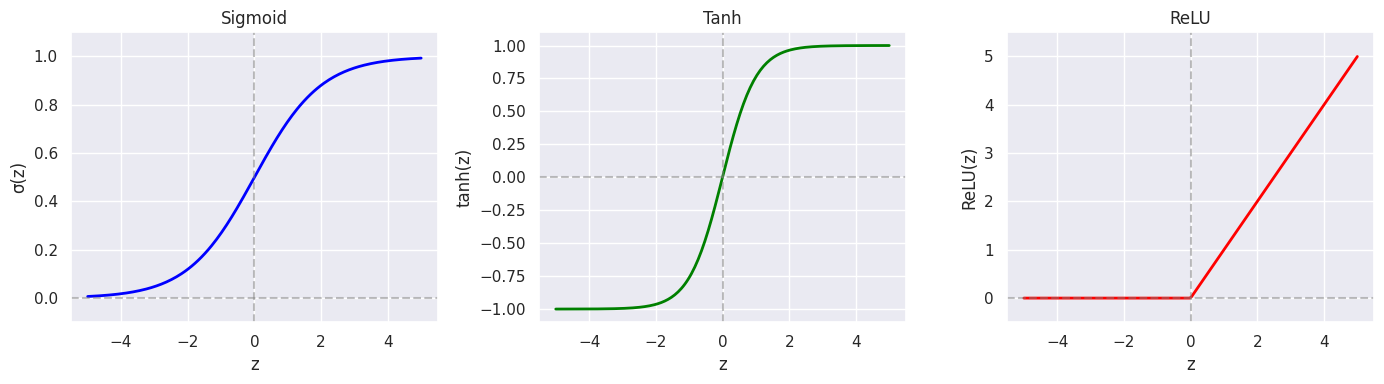

In [41]:
# Visualization of activation functions (run after implementing above)
x = np.linspace(-5, 5, 200)
functions = [
    ('Sigmoid', sigmoid, 'b-', 'σ(z)', (-0.1, 1.1)),
    ('Tanh', tanh, 'g-', 'tanh(z)', (-1.1, 1.1)),
    ('ReLU', relu, 'r-', 'ReLU(z)', (-0.5, 5.5)),
]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (title, func, style, ylabel, ylim) in zip(axes, functions):
    ax.plot(x, func(x), style, linewidth=2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set(title=title, xlabel='z', ylabel=ylabel, ylim=ylim)
plt.tight_layout()
plt.show()

---

## Part 2: Forward Propagation

### 2.1 Network Architecture

We build a simple **2-layer network** (1 hidden layer):

```
Input (100 dims) → Hidden (64 neurons) → Output (6 classes)
       X                 A1                   A2
```

**Shape Rules:**
- Input $X$: $(n_{features}, m)$ where $m$ = batch size
- Weights $W_1$: $(n_{hidden}, n_{features})$
- Bias $b_1$: $(n_{hidden}, 1)$
- Output $W_2$: $(n_{classes}, n_{hidden})$

**Forward Pass:**
$$ Z_1 = W_1 \cdot X + b_1 $$
$$ A_1 = \sigma(Z_1) $$
$$ Z_2 = W_2 \cdot A_1 + b_2 $$
$$ A_2 = \text{softmax}(Z_2) $$

**🚧 TODO:** Implement `forward_prop`.

In [42]:
def forward_prop(X, parameters):
    """
    Perform forward propagation through the network.

    Args:
        X: Input data, shape (n_features, m)
        parameters: Dict with W1, b1, W2, b2

    Returns:
        A2: Output probabilities, shape (n_classes, m)
        cache: Dict with Z1, A1, Z2, A2 for backprop
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # 🚧 TODO: Layer 1 - Linear + Sigmoid
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)

    # 🚧 TODO: Layer 2 - Linear + Softmax
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

### ❓ Question 2

Why do we use sigmoid for the hidden layer but softmax for the output layer?

**Answer:**
🚧 TODO: ...
Sigmoid is used in hidden layers to introduce non-linearity, allowing the network to learn complex boundaries. Without it the network would just be a linear model. Softmax is used at the output because we are doing multi-class classification, it squashes the raw scores into a valid probability distribution (all values positive, sum to 1).

---

## Part 3: Loss & Backward Propagation

### 3.1 Cross-Entropy Loss

For multi-class classification, we use **Cross-Entropy Loss**:
$$ L = -\frac{1}{m} \sum_{i} \sum_{c} Y_{c,i} \log(A2_{c,i}) $$

Where:
- $Y$ is one-hot encoded ground truth
- $A2$ is predicted probabilities from softmax

### 3.2 The Chain Rule

Backpropagation computes gradients using the chain rule:
$$ \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} $$

**Key insight:** For softmax + cross-entropy, the gradient simplifies to:
$$ \frac{\partial L}{\partial Z_2} = A_2 - Y $$

**🚧 TODO:** Implement `compute_loss` and `backward_prop`.

In [1]:
def compute_loss(A2, Y):
    """
    Compute cross-entropy loss.

    🚧 TODO: Implement the formula: -sum(Y * log(A2)) / m
    Hint: Add a small epsilon (1e-8) to avoid log(0)
    """
    m = Y.shape[1]
    epsilon = 1e-8
    A2 = np.clip(A2, epsilon, 1 - epsilon)
    loss = -np.sum(Y * np.log(A2)) / m
    return loss

def backward_prop(parameters, cache, X, Y):
    """
    Compute gradients via backpropagation.

    🚧 TODO: Compute gradients for W1, b1, W2, b2

    Key formulas:
    - dZ2 = A2 - Y
    - dW2 = (1/m) * dZ2 @ A1.T
    - db2 = (1/m) * sum(dZ2, axis=1, keepdims=True)
    - dZ1 = W2.T @ dZ2 * A1 * (1 - A1)  # sigmoid derivative
    - dW1 = (1/m) * dZ1 @ X.T
    - db1 = (1/m) * sum(dZ1, axis=1, keepdims=True)
    """
    m = X.shape[1]
    A2 = cache["A2"]
    A1 = cache["A1"]
    W2 = parameters["W2"]

    # 🚧 TODO: Compute gradients
    dZ2 = A2 - Y
    dW2 = (1/m) * dZ2 @ A1.T
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2) * A1 * (1 - A1)  # sigmoid derivative
    dW1 = (1/m) * dZ1 @ X.T
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

### ❓ Question 3

Why does the derivative of sigmoid $\sigma(z)$ equal $\sigma(z) \cdot (1 - \sigma(z))$?

*Hint: Start with $\sigma(z) = \frac{1}{1+e^{-z}}$ and use the quotient rule.*

**Answer:**
🚧 TODO: ...

---

## Part 4: Training Loop

### 4.1 Gradient Descent

The training loop repeats:
1. **Forward**: Compute predictions
2. **Loss**: Measure error
3. **Backward**: Compute gradients
4. **Update**: Adjust weights

$$ W := W - \alpha \cdot \frac{\partial L}{\partial W} $$

Where $\alpha$ is the **learning rate**.

### 4.2 Test on Dummy Data First

Before using real data, let's verify our network works on random numbers.

In [44]:
# Dummy data
X = np.random.randn(10, 5)  # 10 features, 5 examples
Y = np.zeros((3, 5))        # 3 classes
Y[0, 0] = 1; Y[1, 1] = 1; Y[2, 2] = 1; Y[0, 3] = 1; Y[1, 4] = 1

# Initialize parameters
parameters = {
    "W1": np.random.randn(4, 10) * 0.01,
    "b1": np.zeros((4, 1)),
    "W2": np.random.randn(3, 4) * 0.01,
    "b2": np.zeros((3, 1))
}

# 🚧 TODO: Implement the training loop
learning_rate = 0.1
for i in range(100):
    # 1. Forward pass
    A2, cache = forward_prop(X, parameters)

    # 2. Compute loss
    cost = compute_loss(A2, Y)

    # 3. Backward pass
    grads = backward_prop(parameters, cache, X, Y)

    # 4. Update parameters
    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]
    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]

    if i % 20 == 0:
        print(f"Iter {i}: Cost {cost:.4f}")

print("Training done. Cost should decrease!")

Iter 0: Cost 1.6094
Iter 20: Cost 1.6097
Iter 40: Cost 1.6081
Iter 60: Cost 1.6060
Iter 80: Cost 1.6117
Training done. Cost should decrease!


---

## Part 5: Real Data — StackExchange Classification

Now let's apply our neural network to **real text data**!

### 5.1 The Connection to Previous Notebooks

| Notebook | Representation | Classifier | Approach |
|----------|---------------|------------|----------|
| **NB2** | TF-IDF (sparse) | Logistic Regression | sklearn pipeline |
| **NB3** | Word2Vec averages (dense) | — | Semantic similarity |
| **NB4** | Word2Vec averages (dense) | Neural Network | Our NumPy NN! |

We'll use the same StackExchange dataset from Notebook 2, but represent documents using **averaged word embeddings** (as introduced in Notebook 3).

### 5.2 Load Pre-trained Embeddings

In [45]:
# Load pre-trained embeddings
from pathlib import Path
import re

def load_embeddings(filepath):
    """Load word embeddings from a text file (word2vec format)."""
    word_to_idx = {}
    embeddings_list = []

    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Loading embeddings")):
            parts = line.strip().split()
            if len(parts) < 10:  # Skip header or malformed lines
                continue
            word = parts[0]
            vector = np.array([float(x) for x in parts[1:]])
            word_to_idx[word] = len(embeddings_list)
            embeddings_list.append(vector)

    embeddings = np.array(embeddings_list)
    print(f"Loaded {len(word_to_idx)} words with {embeddings.shape[1]} dimensions")
    return word_to_idx, embeddings

# Load embeddings
EMBED_PATH = Path("/content/enwiki-50k_100d.txt")
w2i, embeddings = load_embeddings(EMBED_PATH)
EMBED_DIM = embeddings.shape[1]

print(f"\nTest: 'king' index = {w2i.get('king', 'NOT FOUND')}")

Loading embeddings: 0it [00:00, ?it/s]

Loaded 50000 words with 100 dimensions

Test: 'king' index = 520


In [46]:
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Sklearn imports
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

try:
    from wordcloud import WordCloud
except ImportError:
    print("⚠️ wordcloud not installed. Run: pip install wordcloud")
# Setup
tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
pd.set_option("display.precision", 3)

In [47]:
import collections
import re
import unicodedata
import os
import zipfile
import urllib.request
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Setup
tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
pd.set_option("display.precision", 2)

# Download and unzip the texts dataset if not already present

DATA_DIR = Path("texts")

if not DATA_DIR.exists():
    print("Downloading texts.zip...")
    url = "https://gerdes.fr/saclay/honlp/texts.zip"
    zip_path = "texts.zip"
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting texts.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

    # Clean up zip file
    os.remove(zip_path)
    print("Done!")

# Verify Data
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Could not find 'texts' directory at {DATA_DIR.absolute()}")

print(f"Data directory: {DATA_DIR.absolute()}")



Data directory: /content/texts


In [48]:
# Load StackExchange data (same as Notebook 2)
DATA_DIR = Path("texts")
CATEGORIES = ["mythology", "woodworking", "robotics", "hsm", "health", "portuguese"]

data = []
for cat_id, category in enumerate(tqdm(CATEGORIES, desc="Loading categories")):
    cat_path = DATA_DIR / category
    if not cat_path.exists():
        print(f"⚠️ Category '{category}' not found, skipping...")
        continue
    for text_file in list(cat_path.glob("*.txt"))[:100]:  # Limit for speed
        with open(text_file, 'r', encoding='utf-8') as f:
            text = f.read()
        data.append({
            "text": text,
            "category": category,
            "cat_id": cat_id
        })

print(f"\nLoaded {len(data)} documents from {len(CATEGORIES)} categories")

import pandas as pd
df = pd.DataFrame(data)
print(df['category'].value_counts())

Loading categories: 100%|██████████| 6/6 [00:00<00:00,  8.62it/s]


Loaded 600 documents from 6 categories
category
mythology      100
woodworking    100
robotics       100
hsm            100
health         100
portuguese     100
Name: count, dtype: int64


### 5.3 Document Embeddings via Averaging

Same approach as Notebook 3: average the word vectors for all words in a document.

$$ \vec{doc} = \frac{1}{n} \sum_{i=1}^{n} \vec{word_i} $$

**🚧 TODO:** Implement `doc_to_vec` function.

In [49]:
def doc_to_vec(text, word_to_idx, embeddings):
    """
    Convert a document to a vector by averaging word embeddings.

    🚧 TODO:
    1. Tokenize text (simple regex: r'\b[a-z]+\b')
    2. Look up embeddings for each token in vocabulary
    3. Average the embeddings
    4. Handle case where no tokens are found (return zero vector)
    """
    # Tokenization
    tokens = re.findall(r'\b[a-z]+\b', text.lower())

    # 🚧 TODO: Get embeddings and average them
    vectors = []
    for token in tokens:
        if token in word_to_idx:
            vectors.append(embeddings[word_to_idx[token]])

    if len(vectors) == 0:
        return np.zeros(embeddings.shape[1])

    return np.mean(vectors, axis=0)

# Test
test_text = "Machine learning and artificial intelligence are transforming the world"
test_vec = doc_to_vec(test_text, w2i, embeddings)
print(f"Test document vector shape: {test_vec.shape}")

Test document vector shape: (100,)


In [50]:
# Convert all documents to embeddings
print("Converting documents to embeddings...")
X_data = np.array([doc_to_vec(row['text'], w2i, embeddings) for row in tqdm(data)])
y_data = np.array([row['cat_id'] for row in data])

print(f"X shape: {X_data.shape}")
print(f"y shape: {y_data.shape}")

# One-hot encode labels
n_classes = len(CATEGORIES)
Y_onehot = np.zeros((len(y_data), n_classes))
Y_onehot[np.arange(len(y_data)), y_data] = 1
print(f"Y one-hot shape: {Y_onehot.shape}")

Converting documents to embeddings...


100%|██████████| 600/600 [00:00<00:00, 1625.77it/s]

X shape: (600, 100)
y shape: (600,)
Y one-hot shape: (600, 6)


In [51]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(
    X_data, Y_onehot, y_data, test_size=0.2, random_state=42, stratify=y_data
)

print(f"Training set: {X_train.shape[0]} documents")
print(f"Test set: {X_test.shape[0]} documents")

# Transpose for our network (features × samples)
X_train_T = X_train.T
X_test_T = X_test.T
Y_train_T = Y_train.T
Y_test_T = Y_test.T

print(f"\nTransposed shapes for NN:")
print(f"X_train: {X_train_T.shape}, Y_train: {Y_train_T.shape}")

Training set: 480 documents
Test set: 120 documents

Transposed shapes for NN:
X_train: (100, 480), Y_train: (6, 480)


### 5.4 Train Our NumPy Neural Network

**🚧 TODO:** Initialize parameters, run training loop, evaluate on test set.

In [52]:
def initialize_parameters(n_input, n_hidden, n_output):
    """Initialize weights with Xavier initialization, biases with zeros."""
    np.random.seed(42)
    parameters = {
        "W1": np.random.randn(n_hidden, n_input) * np.sqrt(2.0 / n_input),
        "b1": np.zeros((n_hidden, 1)),
        "W2": np.random.randn(n_output, n_hidden) * np.sqrt(2.0 / n_hidden),
        "b2": np.zeros((n_output, 1))
    }
    return parameters

def predict(X, parameters):
    """Get class predictions from the network."""
    A2, _ = forward_prop(X, parameters)
    return np.argmax(A2, axis=0)

def accuracy(y_pred, y_true):
    """Compute classification accuracy."""
    return np.mean(y_pred == y_true)

# Initialize network
n_input = EMBED_DIM      # 100 (embedding dimension)
n_hidden = 64            # Hidden layer size
n_output = n_classes     # 6 categories

parameters = initialize_parameters(n_input, n_hidden, n_output)
print(f"Network architecture: {n_input} → {n_hidden} → {n_output}")

Network architecture: 100 → 64 → 6


In [53]:
# 🚧 TODO: Training loop with history tracking
learning_rate = 1.0
n_epochs = 500

history = {"loss": [], "train_acc": [], "test_acc": []}

for epoch in tqdm(range(n_epochs), desc="Training"):
    # Forward pass
    A2, cache = forward_prop(X_train_T, parameters)

    # Compute loss
    loss = compute_loss(A2, Y_train_T)

    # Backward pass
    grads = backward_prop(parameters, cache, X_train_T, Y_train_T)

    # Update parameters
    parameters["W1"] -= learning_rate * grads["dW1"]
    parameters["b1"] -= learning_rate * grads["db1"]
    parameters["W2"] -= learning_rate * grads["dW2"]
    parameters["b2"] -= learning_rate * grads["db2"]

    # Track metrics every 50 epochs
    if epoch % 50 == 0:
        train_pred = predict(X_train_T, parameters)
        test_pred = predict(X_test_T, parameters)
        train_acc = accuracy(train_pred, y_train)
        test_acc = accuracy(test_pred, y_test)

        history["loss"].append(loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

print(f"\nFinal Results:")
print(f"  Train Accuracy: {train_acc:.2%}")
print(f"  Test Accuracy:  {test_acc:.2%}")

Training: 100%|██████████| 500/500 [00:00<00:00, 513.10it/s]


Final Results:
  Train Accuracy: 55.62%
  Test Accuracy:  58.33%


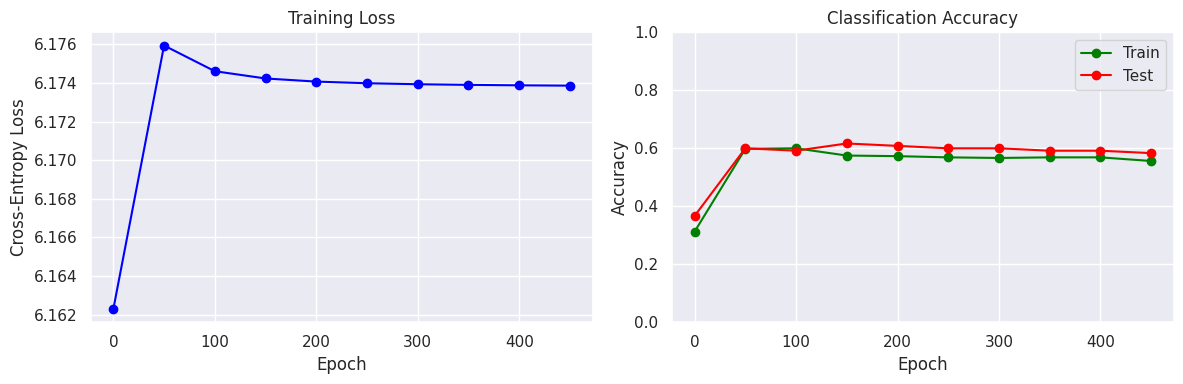

In [54]:
# Visualize training progress
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs_tracked = range(0, n_epochs, 50)

axes[0].plot(epochs_tracked, history["loss"], 'b-o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross-Entropy Loss")
axes[0].set_title("Training Loss")

axes[1].plot(epochs_tracked, history["train_acc"], 'g-o', label="Train")
axes[1].plot(epochs_tracked, history["test_acc"], 'r-o', label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Classification Accuracy")
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

---

## Part 6: Transition to PyTorch

Our NumPy implementation works, but it's tedious:
- Manual gradient computation for every layer
- Easy to make mistakes in backpropagation
- Hard to experiment with different architectures

**PyTorch** solves this with **automatic differentiation**.

### 6.1 NumPy vs PyTorch — Side by Side

| NumPy (Manual) | PyTorch (Automatic) |
|----------------|---------------------|
| `np.dot(W, X) + b` | `nn.Linear(in, out)` |
| `sigmoid(z)` | `torch.sigmoid(z)` |
| `backward_prop()` — 20 lines | `loss.backward()` — 1 line! |
| Manual `W -= lr * dW` | `optimizer.step()` |

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_pt = torch.FloatTensor(X_train).to(device)
X_test_pt = torch.FloatTensor(X_test).to(device)
y_train_pt = torch.LongTensor(y_train).to(device)  # Class indices, not one-hot
y_test_pt = torch.LongTensor(y_test).to(device)

print(f"X_train tensor shape: {X_train_pt.shape}")
print(f"y_train tensor shape: {y_train_pt.shape}")

Using device: cpu
X_train tensor shape: torch.Size([480, 100])
y_train tensor shape: torch.Size([480])


### 6.2 Define the Same Network in PyTorch

**🚧 TODO:** Create a 2-layer network matching our NumPy version.

In [58]:
class TextClassifier(nn.Module):
    """
    A simple 2-layer feedforward network for text classification.
    Same architecture as our NumPy version!

    🚧 TODO: Define layers matching:
        Input (100) → Hidden (64) → Output (6)
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()  # Don't forget this!

        # 🚧 TODO: Define layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 🚧 TODO: Forward pass
        x = self.fc1(x)
        x = torch.sigmoid(x) # Layer 1 + activation
        x = self.fc2(x)      # Layer 2 (no softmax - CrossEntropyLoss includes it)
        return x

# Create model
model = TextClassifier(
    input_dim=EMBED_DIM,
    hidden_dim=64,
    output_dim=n_classes
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

TextClassifier(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

Total parameters: 6,854


### 6.3 Training in PyTorch — The Magic of Autograd

**🚧 TODO:** Implement the PyTorch training loop.

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1.0)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_pt, y_train_pt)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 🚧 TODO: Training loop
n_epochs_pt = 100
history_pt = {"loss": [], "train_acc": [], "test_acc": []}

for epoch in tqdm(range(n_epochs_pt), desc="PyTorch Training"):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        # 🚧 TODO: Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # 🚧 TODO: Backward pass (3 lines!)
        optimizer.zero_grad()  # zero gradients
        loss.backward()        # compute gradients
        optimizer.step()       # update weights

        epoch_loss += loss.item()

    # Track metrics every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_pt).argmax(dim=1)
            test_pred = model(X_test_pt).argmax(dim=1)
            train_acc = (train_pred == y_train_pt).float().mean().item()
            test_acc = (test_pred == y_test_pt).float().mean().item()

            history_pt["loss"].append(epoch_loss / len(train_loader))
            history_pt["train_acc"].append(train_acc)
            history_pt["test_acc"].append(test_acc)

print(f"\nPyTorch Results:")
print(f"  Train Accuracy: {train_acc:.2%}")
print(f"  Test Accuracy:  {test_acc:.2%}")

PyTorch Training: 100%|██████████| 100/100 [00:01<00:00, 70.33it/s]


PyTorch Results:
  Train Accuracy: 98.54%
  Test Accuracy:  94.17%


### ❓ Question 4

Compare the PyTorch training loop to our NumPy version. What are the 3 lines that replace our 20-line `backward_prop` function?

**Answer:**
🚧 TODO: ...
lines that replace our manual 20-line backpropagation function are:


*   optimizer.zero_grad(): Clears old gradients
*   loss.backward(): Computes new gradients using automatic differentiation
*   optimizer.step(): Updates the model parameters using those gradients


---

## Part 7: Deep Averaging Network (DAN)

So far we've used **pre-computed** averaged embeddings. But what if we could **learn** the embeddings as part of training?

### 7.1 The Embeddings Layer

`nn.Embedding` is a **lookup table** that maps token IDs to vectors:

```python
embedding = nn.Embedding(vocab_size=10000, embedding_dim=100)
tokens = torch.LongTensor([[1, 42, 7, 3]])  # One sequence of 4 tokens
vectors = embedding(tokens)  # Shape: (1, 4, 100)
```

The key insight: **these vectors are trainable parameters!**

### 7.2 Deep Averaging Network Architecture

```
    Tokens           Embeddings         Averaged        Hidden         Output
[I, love, NLP]  →  [v_I, v_love, v_NLP]  →  mean()  →  Linear+ReLU  →  Linear  →  Classes
    (3,)              (3, 100)              (100,)       (64,)          (6,)
```

In [61]:
# First, we need to convert text to token IDs

def build_vocabulary(texts, max_vocab=10000, min_freq=2):
    """Build a word-to-index vocabulary from texts."""
    word_counts = {}
    for text in texts:
        tokens = re.findall(r'\b[a-z]+\b', text.lower())
        for token in tokens:
            word_counts[token] = word_counts.get(token, 0) + 1

    sorted_words = sorted(word_counts.items(), key=lambda x: -x[1])
    vocab = {"<PAD>": 0, "<UNK>": 1}  # Special tokens

    for word, count in sorted_words:
        if count >= min_freq and len(vocab) < max_vocab:
            vocab[word] = len(vocab)

    return vocab

def text_to_ids(text, vocab, max_len=100):
    """Convert text to a fixed-length sequence of token IDs."""
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens[:max_len]]

    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))

    return ids

# Build vocabulary
all_texts = [row['text'] for row in data]
vocab = build_vocabulary(all_texts)
print(f"Vocabulary size: {len(vocab)}")

# Convert all documents to token IDs
MAX_LEN = 100
X_ids = np.array([text_to_ids(row['text'], vocab, MAX_LEN) for row in tqdm(data, desc="Tokenizing")])
print(f"Token IDs shape: {X_ids.shape}")

Vocabulary size: 10000


Tokenizing: 100%|██████████| 600/600 [00:00<00:00, 5426.90it/s]

Token IDs shape: (600, 100)


### 7.3 Define the Deep Averaging Network

**🚧 TODO:** Create a DAN with:
1. `nn.Embedding` layer
2. Averaging over sequence dimension
3. Hidden layer with ReLU
4. Output layer

In [63]:
class DeepAveragingNetwork(nn.Module):
    """
    Deep Averaging Network: Learn embeddings end-to-end!

    Architecture:
        Token IDs → Embedding → Mean → Hidden → Output

    🚧 TODO: Implement the DAN architecture
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, padding_idx=0):
        super().__init__()

        # 🚧 TODO: Define layers
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x shape: (batch_size, seq_len) — token IDs

        # 🚧 TODO: Get embeddings
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        # 🚧 TODO: Average over sequence (handle padding!)
        mask = (x != 0).unsqueeze(-1).float()
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        averaged = summed / lengths

        # 🚧 TODO: Classification layers
        hidden = self.fc1(averaged)
        hidden = torch.relu(hidden)
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)

        return output

# Create DAN model
dan_model = DeepAveragingNetwork(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=64,
    output_dim=n_classes
).to(device)

print(dan_model)
print(f"\nTotal parameters: {sum(p.numel() for p in dan_model.parameters()):,}")

DeepAveragingNetwork(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 1,006,854


In [64]:
# Prepare data for DAN
X_ids_train, X_ids_test, y_dan_train, y_dan_test = train_test_split(
    X_ids, y_data, test_size=0.2, random_state=42, stratify=y_data
)

X_ids_train_pt = torch.LongTensor(X_ids_train).to(device)
X_ids_test_pt = torch.LongTensor(X_ids_test).to(device)
y_dan_train_pt = torch.LongTensor(y_dan_train).to(device)
y_dan_test_pt = torch.LongTensor(y_dan_test).to(device)

# Training setup
dan_criterion = nn.CrossEntropyLoss()
dan_optimizer = optim.Adam(dan_model.parameters(), lr=0.001)

dan_train_dataset = TensorDataset(X_ids_train_pt, y_dan_train_pt)
dan_train_loader = DataLoader(dan_train_dataset, batch_size=32, shuffle=True)

# 🚧 TODO: Training loop (similar to before)
n_epochs_dan = 50
history_dan = {"loss": [], "train_acc": [], "test_acc": []}

for epoch in tqdm(range(n_epochs_dan), desc="Training DAN"):
    dan_model.train()
    epoch_loss = 0

    for X_batch, y_batch in dan_train_loader:
        # Forward, loss, backward, step
        dan_optimizer.zero_grad()
        outputs = dan_model(X_batch)
        loss = dan_criterion(outputs, y_batch)
        loss.backward()
        dan_optimizer.step()

        epoch_loss += loss.item()

    # Track metrics
    if epoch % 5 == 0:
        dan_model.eval()
        with torch.no_grad():
            train_out = dan_model(X_ids_train_pt)
            test_out = dan_model(X_ids_test_pt)
            train_acc = (train_out.argmax(1) == y_dan_train_pt).float().mean().item()
            test_acc = (test_out.argmax(1) == y_dan_test_pt).float().mean().item()

            history_dan["loss"].append(epoch_loss / len(dan_train_loader))
            history_dan["train_acc"].append(train_acc)
            history_dan["test_acc"].append(test_acc)

print(f"\nDAN Final Results:")
print(f"  Train Accuracy: {train_acc:.2%}")
print(f"  Test Accuracy:  {test_acc:.2%}")

Training DAN: 100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


DAN Final Results:
  Train Accuracy: 100.00%
  Test Accuracy:  80.83%


### ❓ Question 5

You should observe **overfitting** (high train accuracy, lower test accuracy).
1. Why does DAN overfit so severely?
2. What is the ratio of parameters to training examples?
3. What are some solutions?

**Answer:**
🚧 TODO: ...

---

## Part 8: Why Order Matters — Limitations of Bag-of-Words

### 8.1 The Problem

Our DAN treats text as a **bag of words** — the order doesn't matter!

Consider these sentences:
- "The **dog** bit the **man**"
- "The **man** bit the **dog**"

They have the **exact same averaged embedding** but **completely different meanings**!

In [65]:
# Demonstration: same words, different meanings
sentence_pairs = [
    ("The dog bit the man", "The man bit the dog"),
    ("I love working, not sleeping", "I love sleeping, not working"),
    ("The movie was not good at all", "The movie was good, not bad at all"),
]

print("=== Bag-of-Words Fails to Distinguish These Pairs ===\n")

for i, (s1, s2) in enumerate(sentence_pairs):
    v1 = doc_to_vec(s1, w2i, embeddings)
    v2 = doc_to_vec(s2, w2i, embeddings)

    cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-10)

    print(f'"{s1}"')
    print(f'"{s2}"')
    print(f"Cosine similarity: {cos_sim:.4f}")
    print()

=== Bag-of-Words Fails to Distinguish These Pairs ===

"The dog bit the man"
"The man bit the dog"
Cosine similarity: 1.0000

"I love working, not sleeping"
"I love sleeping, not working"
Cosine similarity: 1.0000

"The movie was not good at all"
"The movie was good, not bad at all"
Cosine similarity: 0.9829



### 8.2 Solutions: Modeling Sequence Order

| Approach | Key Idea | Pros | Cons |
|----------|----------|------|------|
| **N-grams** | Include "dog bit" as feature | Simple | Vocabulary explosion |
| **Positional Encoding** | Add position info to embeddings | Works with averaging | Fixed context window |
| **RNNs (LSTM, GRU)** | Process tokens sequentially | Natural for sequences | Hard to parallelize, forgets long context |
| **Transformers** | Attention over all positions | Captures long-range, parallelizable | Compute-heavy |

### 8.3 Preview: The Attention Mechanism

**The key insight of Transformers:** Instead of averaging all words equally, **learn which words to pay attention to** based on context.

We'll explore this in **Notebook 5: Transformers & LLMs**.

---

## Part 9: Experiments & Debugging

### 9.1 Hyperparameter Exploration

**🚧 TODO:** Run the experiments below and interpret the results.

In [66]:
def train_model_with_config(hidden_dim, learning_rate, activation='sigmoid', n_epochs=100):
    """Train a model with specified hyperparameters and return test accuracy."""

    class ConfigurableNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(EMBED_DIM, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, n_classes)
            self.activation = activation

        def forward(self, x):
            x = self.fc1(x)
            if self.activation == 'sigmoid':
                x = torch.sigmoid(x)
            elif self.activation == 'relu':
                x = torch.relu(x)
            elif self.activation == 'tanh':
                x = torch.tanh(x)
            elif self.activation == 'none':
                pass
            x = self.fc2(x)
            return x

    model = ConfigurableNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        model.train()
        outputs = model(X_train_pt)
        loss = criterion(outputs, y_train_pt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_pt).argmax(1)
        test_acc = (test_pred == y_test_pt).float().mean().item()

    return test_acc

# Experiment 1: Hidden layer size
print("=== Experiment 1: Hidden Layer Size ===")
hidden_sizes = [4, 16, 64, 256]
for h in hidden_sizes:
    acc = train_model_with_config(hidden_dim=h, learning_rate=0.5)
    print(f"  Hidden size {h:3d}: {acc:.2%}")

=== Experiment 1: Hidden Layer Size ===
  Hidden size   4: 45.00%
  Hidden size  16: 70.83%
  Hidden size  64: 78.33%
  Hidden size 256: 29.17%


**📝 TODO: Interpret Experiment 1 results**

🚧 TODO: Why does a very small hidden size perform poorly? Why does a very large hidden size also perform poorly?

In [67]:
# Experiment 2: Learning rate
print("\n=== Experiment 2: Learning Rate ===")
learning_rates = [0.001, 0.01, 0.1, 1.0, 10.0]
for lr in learning_rates:
    acc = train_model_with_config(hidden_dim=64, learning_rate=lr)
    print(f"  LR {lr:6.3f}: {acc:.2%}")

# Experiment 3: Activation function
print("\n=== Experiment 3: Activation Function ===")
activations = ['sigmoid', 'relu', 'tanh', 'none']
for act in activations:
    acc = train_model_with_config(hidden_dim=64, learning_rate=0.5, activation=act)
    print(f"  {act:8s}: {acc:.2%}")


=== Experiment 2: Learning Rate ===
  LR  0.001: 16.67%
  LR  0.010: 22.50%
  LR  0.100: 59.17%
  LR  1.000: 45.83%
  LR 10.000: 32.50%

=== Experiment 3: Activation Function ===
  sigmoid : 78.33%
  relu    : 90.00%
  tanh    : 89.17%
  none    : 90.00%


**📝 TODO: Interpret Experiments 2 & 3 results**

🚧 TODO: What happens when the learning rate is too small? Too large?

🚧 TODO: Why do ReLU and Tanh outperform Sigmoid?

### 9.2 Debugging Exercise: Fix the Broken Network

The following network has **4 bugs**. Can you find and fix them?

**🚧 TODO:** Identify and explain each bug.

In [74]:
# 🐛 BUGGY CODE — 4 bugs to find!
class BrokenNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        # BUG 1: Missing super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)  # BUG 2: Shape mismatch (hidden_dim vs hidden_dim // 2)

    def forward(self, x):
        x = self.fc1(x)
        # BUG 3: Missing activation function (e.g., F.relu(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)  # BUG 4: Incorrect output activation (CrossEntropyLoss expects logits)
        return x

# 🚧 TODO: What are the 4 bugs? Write them below:
# Bug 1: Missing super().__init__() call required for PyTorch modules.
# Bug 2: Dimension mismatch: fc1 outputs 'hidden_dim', but fc2 expects 'hidden_dim // 2'.
# Bug 3: Missing non-linear activation (ReLU) between layers, making the network linear.
# Bug 4: Using sigmoid at output. CrossEntropyLoss expects raw logits, not probabilities.

In [75]:
# 🚧 TODO: Write the fixed version
class FixedNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()  # Fix 1: Initialize parent class
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Fix 2: Correct input dim

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)  # Fix 3: Add non-linearity
        x = self.fc2(x)    # Fix 4: Return logits (no sigmoid)
        return x

# Test your fix
fixed_model = FixedNetwork(EMBED_DIM, 64, n_classes).to(device)
print("Fixed network works!")
print(fixed_model)

Fixed network works!
FixedNetwork(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


---

## Summary & Key Takeaways

### What We Built

```
Notebook 4 Journey:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

NumPy from Scratch          →  PyTorch Framework  →  Deep Averaging Network
                                                    
┌─────────────────┐         ┌─────────────────┐   ┌─────────────────┐
│ sigmoid()       │         │ torch.sigmoid() │   │ nn.Embedding()  │
│ softmax()       │    →    │ nn.Linear()     │ → │ mean pooling    │
│ forward_prop()  │         │ loss.backward() │   │ end-to-end      │
│ backward_prop() │         │ optimizer.step()│   │ learned vectors │
└─────────────────┘         └─────────────────┘   └─────────────────┘
    (understand)                (use)                (apply)
```

### Connections Across Notebooks

```
Notebook 2                    Notebook 3                    Notebook 4
━━━━━━━━━━                    ━━━━━━━━━━                    ━━━━━━━━━━
TF-IDF (sparse)          →   Word2Vec (dense)         →   Neural Networks
                              
sklearn.LogisticRegression    doc_to_vec() averaging       DAN with nn.Embedding
                              
Linear classifier             Pre-trained embeddings       Learned embeddings
```

### What's Next: Notebook 5

The **limitation** we discovered: averaging ignores word order.

**Notebook 5** explores the solution:
- **Transformers** and the **attention mechanism**
- Contextual embeddings (BERT, GPT)
- Fine-tuning pre-trained language models

In [76]:
# Final comparison
print("=" * 60)
print("FINAL COMPARISON: StackExchange Classification")
print("=" * 60)

results = {
    "NumPy NN (Embeddings Avg)": history["test_acc"][-1] if history["test_acc"] else 0,
    "PyTorch NN (Embeddings Avg)": history_pt["test_acc"][-1] if history_pt["test_acc"] else 0,
    "Deep Averaging Network (Learned)": history_dan["test_acc"][-1] if history_dan["test_acc"] else 0,
}

for method, acc in results.items():
    bar = "█" * int(acc * 40)
    print(f"{method:35s} {acc:6.2%} {bar}")

print("\n🚀 Ready for Notebook 5: Transformers!")

FINAL COMPARISON: StackExchange Classification
NumPy NN (Embeddings Avg)           58.33% ███████████████████████
PyTorch NN (Embeddings Avg)         94.17% █████████████████████████████████████
Deep Averaging Network (Learned)    80.83% ████████████████████████████████

🚀 Ready for Notebook 5: Transformers!
